# Первичный анализ данных

Будет анализировать датасет автокатастроф Франции с 2005 по 2016г. Изначально его опубликовало правительство Франции (https://static.data.gouv.fr/resources/base-de-donnees-accidents-corporels-de-la-circulation/20180927-112352/description-des-bases-de-donnees-onisr-annees-2005-a-2017.pdf), поэтому поля имеют такие странные названия

Датасет разбит на 5 файлов:
* `caracteristics` описывает общие обстоятельства аварии и содержит поля:
    1. Num_Acc - уникальный ID
    2. an - год (5-16)
    3. mois - месяц
    4. jour - день
    5. hrmn - время в формате hhmm
    6. lum - условия освещения, где произошла авария (1-5 от ясного дня до ночи без общественного освещения)
    7. agg - флаг населенного пункта
    8. int - тип аварии (переезд путей, столкновение в круговом движении и т.д)
    9. atm - погодные условия (нормальные, легкий дождь, сильный ветер и т.п)
    10. col - тип столкновения (фронтально, сбоку, множественное столкновение и др.)
    11. com, dep - номер, установленный статистическим бюро, интерес не представляет
    12. adr, lat, long - адрес и координаты
    13. gps - M,A,G,R,Y - сокращения департаментов  

* `places` описывает места аварии:
    1. Num_Acc - уникальный ID
    2. catr - тип дороги (проселочная, магистраль и др.)
    3. voie, V1, V2 - номера дорог, много Nan-ов интерес не представляют
    4. circ - тип движения (одностороннее, двусторонее, переменные)
    5. nbv - число полос
    6. vosp - велосипедная дорожка/выделенная полоса
    7. prof - уклон дороги
    8. pr, pr1 - номера терминалов, интерес не представляют, много Nan-ов
    9. surf - состояние поверхности (влага, снег, лёд)
    10. env1 - флаг события рядом со школой
    11. lartpc, larrout - параметры проезжей части (ширина и т.п)

* `users` описывает участников аварии:
    1. Num_Acc - уникальный ID
    2. Num_Veh - категория транспортного средства
    3. catu - категория пользователя (пассажир, водитель, пешеход, скейтбордист)
    4. sex - пол
    5. Year_on - год рождения
    6. trip - тип поездки (дом - работа, работа - учеба и др.)
    7. secu - наличие шлемов/ремней безопасности/детского кресла
    8. actp - действия для пешехода (переходил дорогу, играл на дороге и др.)
    9. etatp - пешеход находился в группе или был один
    10. locp - расстояния до пешехода (>50м), включены ли сигнальные огни
    11. **grav** - самое важное поле - суровость аварии - убит/госпитализирован/жив с ранениями/невредим

* `vehicles` описывает транспортное средство, интересны лишь следующие поля:
    1. Num_Acc - уникальный ID
    2. catv - категория транспортного средства
    3. obsm - c кем столкнулось (пешеход, автомобиль, дикое животное и др.)

Дополнительно для проверки гипотезы загрузим таблицу с праздниками во Франции  
* `holidays` описывает праздник в формате (дата - название)

Цель проекта - обнаружить закономерности в автопроисшествиях, посмотреть динамику, построить прогноз, ~~удовлетворить любопытство.~~
Исследование разобъем на три части - визуализация данных, проверка гипотез, построение прогноза

# Предобработка данных

In [1]:
import pandas as pd
import numpy as np

In [2]:
df1 = pd.read_csv('caracteristics.csv', low_memory = False, encoding = 'latin-1')
df2 = pd.read_csv('vehicles.csv', low_memory = False)
df3 = pd.read_csv('places.csv', low_memory = False)
df4 = pd.read_csv('users.csv', low_memory = False)

In [3]:
from functools import reduce
accidents = reduce(lambda left, right: pd.merge(left, right, on = "Num_Acc"), [df1, df2, df3, df4])

In [4]:
accidents.head()

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,...,catu,grav,sexe,trajet,secu,locp,actp,etatp,an_nais,num_veh_y
0,201600000001,16,2,1,1445,1,2,1,8.0,3.0,...,1,1,2,0.0,11.0,0.0,0.0,0.0,1983.0,B02
1,201600000001,16,2,1,1445,1,2,1,8.0,3.0,...,1,3,1,9.0,21.0,0.0,0.0,0.0,2001.0,A01
2,201600000001,16,2,1,1445,1,2,1,8.0,3.0,...,1,1,2,0.0,11.0,0.0,0.0,0.0,1983.0,B02
3,201600000001,16,2,1,1445,1,2,1,8.0,3.0,...,1,3,1,9.0,21.0,0.0,0.0,0.0,2001.0,A01
4,201600000002,16,3,16,1800,1,2,6,1.0,6.0,...,1,3,1,5.0,11.0,0.0,0.0,0.0,1960.0,A01


In [5]:
total_nans = accidents.isnull().sum().sort_values(ascending = False)

In [6]:
total_nans[:10]

v2       3394326
v1       2129664
long     1970347
lat      1970327
gps      1953913
pr1      1646623
pr       1641293
adr       663606
voie      220467
place     104090
dtype: int64

Удалим столбцы с большим количеством пропусков

In [7]:
accidents = accidents.drop(['v2', 'v1', 'long', 'lat', 'gps', 'pr1', 'pr'], axis = 1)

Удалим неинформативные поля

In [8]:
accidents = accidents.drop(['adr', 'voie', 'place', 'lartpc', 'larrout'], axis = 1)

In [9]:
accidents.head()

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,...,catu,grav,sexe,trajet,secu,locp,actp,etatp,an_nais,num_veh_y
0,201600000001,16,2,1,1445,1,2,1,8.0,3.0,...,1,1,2,0.0,11.0,0.0,0.0,0.0,1983.0,B02
1,201600000001,16,2,1,1445,1,2,1,8.0,3.0,...,1,3,1,9.0,21.0,0.0,0.0,0.0,2001.0,A01
2,201600000001,16,2,1,1445,1,2,1,8.0,3.0,...,1,1,2,0.0,11.0,0.0,0.0,0.0,1983.0,B02
3,201600000001,16,2,1,1445,1,2,1,8.0,3.0,...,1,3,1,9.0,21.0,0.0,0.0,0.0,2001.0,A01
4,201600000002,16,3,16,1800,1,2,6,1.0,6.0,...,1,3,1,5.0,11.0,0.0,0.0,0.0,1960.0,A01


# Визуальный анализ данных

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
sns.set(style="ticks")

In [11]:
accidents.grav.value_counts(sort=False)

1    1562171
2      82151
3     668756
4    1240898
Name: grav, dtype: int64

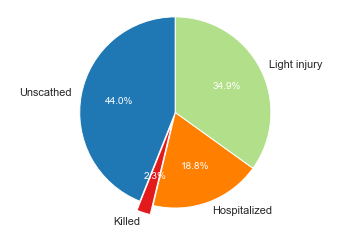

In [12]:
labels = ['Unscathed', 'Killed', 'Hospitalized', 'Light injury']
sizes = list(accidents.grav.value_counts(sort=False))
explode = (0, 0.1, 0, 0)
cmap = plt.get_cmap("Paired")
inner_colors = cmap([1, 5, 7, 2])
fig1, ax1 = plt.subplots()
_, _, autotexts = ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=inner_colors)
for autotext in autotexts:
    autotext.set_color('white')
ax1.axis('equal')
plt.show()

Т.е. летальный исход происходит в 2.3% случаев

Text(0, 0.5, '# of accidents')

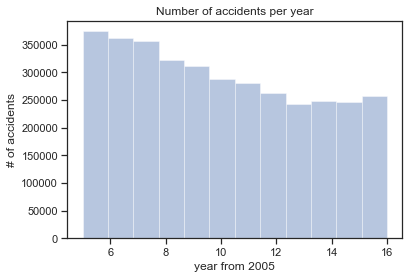

In [13]:
ax = sns.distplot(accidents.an,bins=12,kde=False)
plt.title('Number of accidents per year')
plt.xlabel('year from 2005')
plt.ylabel('# of accidents')

Число аварий уверенно падало до 2013

Text(0, 0.5, '# of accidents')

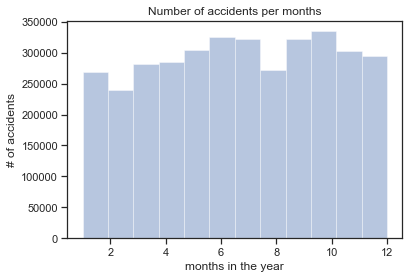

In [14]:
ax = sns.distplot(accidents.mois, bins=12, kde=False);
plt.title('Number of accidents per months')
plt.xlabel('months in the year')
plt.ylabel('# of accidents')

В Феврале меньше всего аварий (видимо из-за количества дней), а в Июне, Июле, Сентябре, Октябре - больше всего, возможно, дело в туризме

Text(0, 0.5, 'Number of accidents')

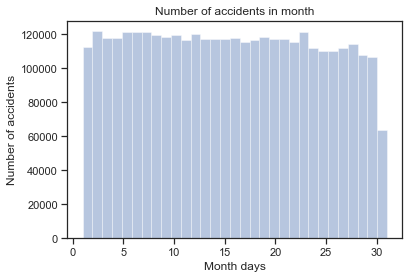

In [15]:
ax = sns.distplot(accidents.jour, bins=31,kde=False)
plt.title('Number of accidents in month')
plt.xlabel('Month days')
plt.ylabel('Number of accidents')

Самый безопасный день месяца - 31-ый, ведь он бывает не всегда :)

Text(0, 0.5, '# of accidents')

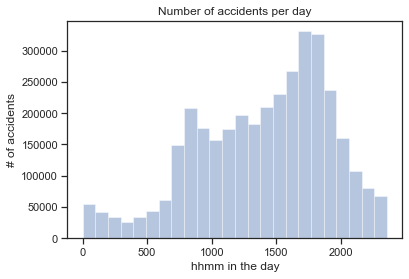

In [16]:
ax = sns.distplot(accidents.hrmn, bins=24, kde=False);
plt.title('Number of accidents per day')
plt.xlabel('hhmm in the day')
plt.ylabel('# of accidents')

Интересное наблюдение - большинство аварий происходит с 17:00 до 19:00, самое безопасное время для поездки - 3 часа утра. Есть и второй локальный максимум - утром, когда люди спешат на работу.

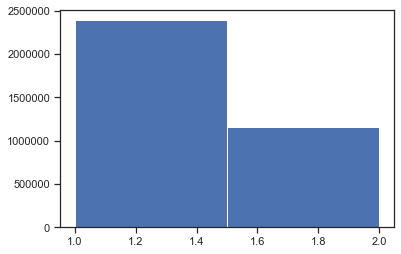

In [17]:
ax = accidents.sexe.hist(bins=2, grid=False)

Мужчины попадают в аварии гораздо чаще

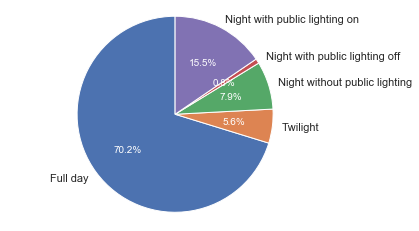

In [18]:
labels = ['Full day', 'Twilight', 'Night without public lighting', 'Night with public lighting off', 'Night with public lighting on']
sizes = list(accidents.lum.value_counts(sort=False).sort_index())
explode = (0, 0, 0, 0, 0)
cmap = plt.get_cmap("Paired")
fig1, ax1 = plt.subplots()
_, _, autotexts = ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
ax1.axis('equal')
plt.show()

Довольно странно, но большинство происшествий было днём

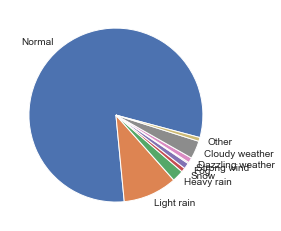

In [19]:
labels = ['Normal', 'Light rain', 'Heavy rain', 'Snow', 'Fog', 'Strong wind', 'Dazzling weather', 'Cloudy weather', 'Other']
sizes = list(accidents.atm.value_counts(sort=False).sort_index())
explode = [0] * len(sizes)
fig1, ax1 = plt.subplots()
_, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, autopct='',
        shadow=False, startangle=-15)

for autotext in texts:
    autotext.set_fontsize(10)
plt.show()

Более того, погода не является определяющим фактором

#### Перейдем к анализу временного ряда

Переведем отдельные столбцы дня/месяца/года в одно поле

In [20]:
df1.an = df1.an + 2000

In [21]:
df1['date']= df1.apply(lambda row : datetime.date(row.an,row.mois,row.jour), axis=1)

In [22]:
df1['date'] = pd.to_datetime(df1['date'])

Объединим данные по дням

In [23]:
df1.index = df1['date'] 
day_resample = df1.resample('D').count()

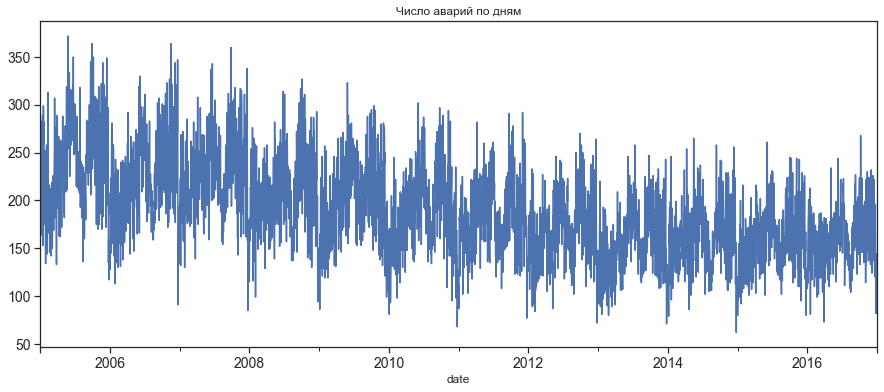

In [24]:
day_resample.Num_Acc.plot(figsize=(15,6),title= 'Число аварий по дням', fontsize=14)

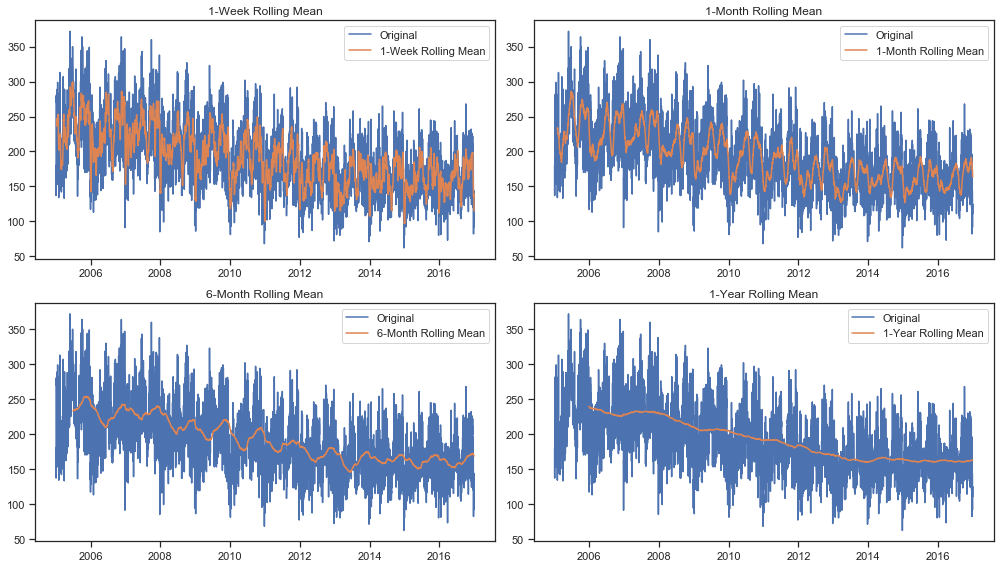

In [25]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)

window = 7
axes[0][0].plot(day_resample.index, day_resample.Num_Acc, label='Original')
axes[0][0].plot(day_resample.index, day_resample.Num_Acc.rolling(window=window).mean(), label='1-Week Rolling Mean')
axes[0][0].set_title("1-Week Rolling Mean")
axes[0][0].legend(loc='best')

window = 30
axes[0][1].plot(day_resample.index, day_resample.Num_Acc, label='Original')
axes[0][1].plot(day_resample.index, day_resample.Num_Acc.rolling(window=window).mean(), label='1-Month Rolling Mean')
axes[0][1].set_title("1-Month Rolling Mean")
axes[0][1].legend(loc='best')

window = 6*30
axes[1][0].plot(day_resample.index, day_resample.Num_Acc, label='Original')
axes[1][0].plot(day_resample.index, day_resample.Num_Acc.rolling(window=window).mean(), label='6-Month Rolling Mean')
axes[1][0].set_title("6-Month Rolling Mean")
axes[1][0].legend(loc='best')

window = 12*30
axes[1][1].plot(day_resample.index, day_resample.Num_Acc, label='Original')
axes[1][1].plot(day_resample.index, day_resample.Num_Acc.rolling(window=window).mean(), label='1-Year Rolling Mean')
axes[1][1].set_title("1-Year Rolling Mean")
axes[1][1].legend(loc='best')

plt.tight_layout()
plt.show()

Разложим ряд на составляющие

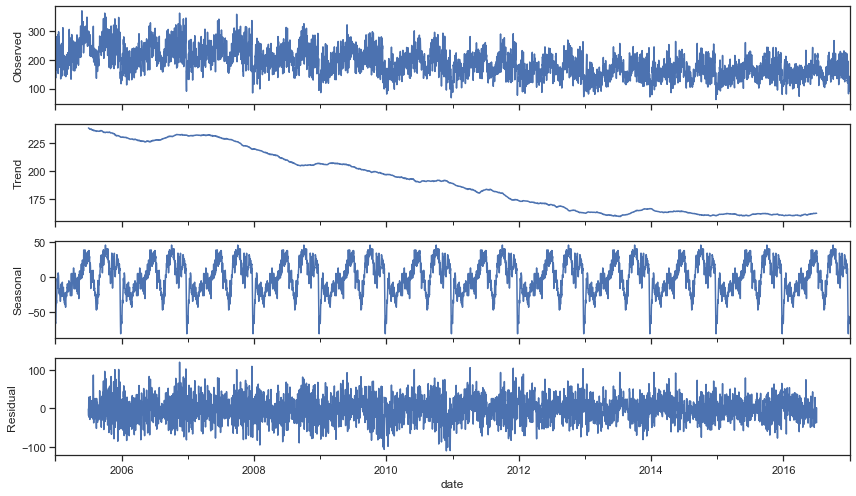

In [26]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 12, 7
# STL-декомпозиция ряда
result = sm.tsa.seasonal_decompose(day_resample.Num_Acc, model='additive',freq = 365)
result.plot()
plt.show()

# Проверка статистических гипотез

### Проверим гипотезу  
> H0: шанс погибнуть без наличия защиты (ремень, шлем и др.) больше

In [27]:
from scipy import stats

In [28]:
safety = accidents[['secu', 'grav']]

In [29]:
safety.head()

,secu,grav
0,11.0,1
1,21.0,3
2,11.0,1
3,21.0,3
4,11.0,3


Напоминание:
* Поле grav:  
    1 - Unscathed  
    2 - Killed  
    3 - Hospitalized wounded  
    4 - Light injury  
* Поле secu:  
    Первая цифра  
    1 - Belt  
    2 - Helmet  
    3 - Children's device  
    4 - Reflective equipment  
    9 - Other  
    Вторая цифра - использовалось ли эта экипировка  
    1 - Yes  
    2 - No  
    3 - Not determinable  

In [30]:
d1 = dict(safety.dropna().secu.value_counts())

In [31]:
d2 = dict(safety[safety.grav == 2].dropna().secu.value_counts())

Подсчитаем относительное число погибших людей использующих данное средство к числу всех людей, использующих это средство защиты

In [32]:
d3 = dict()
for elem in d1:
    if elem in d2:
        if elem > 10 and elem % 10 != 3 and elem % 10 != 0:
            d3[elem] = d2[elem] / d1[elem]

In [33]:
list_of_pairs = sorted(d3.items(), key=lambda x: x[0])

In [34]:
list_of_pairs

[(11.0, 0.015913711528552022),
 (12.0, 0.15085887897791453),
 (21.0, 0.03199911087118747),
 (22.0, 0.06804776709184415),
 (31.0, 0.014533606677405183),
 (32.0, 0.07771609833465504),
 (41.0, 0.04308594631175276),
 (42.0, 0.09320754716981132),
 (91.0, 0.019089217827388174),
 (92.0, 0.03131659408876123)]

In [35]:
list_with_equipment = []
list_without_equipment = []
for i in range(0, len(list_of_pairs) - 1, 2):
    list_with_equipment.append(list_of_pairs[i][1])
    list_without_equipment.append(list_of_pairs[i+1][1])

Применим двувыборочный критерий с несвязанными выборками Манна-Уитни  
Его применение уместно так как:  
* Критерий подходит для сравнения малых выборок - у нас по 5 значений на каждый из видов защиты
* Может показаться что у нас парные данные, но это не так - люди использующие и неиспользующие средства безопасности различные и мы проверяем что в среднем не использовать защиту хуже, не опираясь на сам вид защиты

In [36]:
stats.mannwhitneyu(list_without_equipment, list_with_equipment, alternative = 'less')

MannwhitneyuResult(statistic=23.0, pvalue=0.9892141260261396)

Принимаем гипотезу, что без экипировки смертность выше

### Проверим гипотезу  

> H0: Число аварий во время праздников не меняется

Подгрузим дополнительный датасет праздников Франции

In [37]:
df5 = pd.read_csv('holidays.csv', low_memory = False)

In [38]:
df5.head(7)

,ds,holiday
0,2005-01-01,New year
1,2005-03-28,Easter Monday
2,2005-05-01,Labour Day
3,2005-05-05,Ascension Thursday
4,2005-05-08,Victory in Europe Day
5,2005-05-16,Whit Monday
6,2005-07-14,Bastille Day


In [39]:
dates = list(df5.ds)

In [40]:
acc_in_holidays = []
acc_not_in_holidays = []

Будем извлекать данные в день праздника, а так же за неделю до и после него (верим в сезонность недели) и усредняем две последние величины. Проверять будем имеется ли статистически значимая разница в день праздника и этот же день за неделю до и после него.

In [41]:
from datetime import timedelta

indexes = day_resample.index
for date in dates:
    
    acc_in_holidays.append(day_resample.loc[date].Num_Acc)
    
    one_week_before = (datetime.datetime.strptime(date, '%Y-%m-%d') - timedelta(days=7)).strftime("%Y-%m-%d")
    one_week_after = (datetime.datetime.strptime(date, '%Y-%m-%d') + timedelta(days=7)).strftime("%Y-%m-%d")
    
    if one_week_before in indexes and one_week_after in indexes:
        acc_not_in_holidays.append((day_resample.loc[one_week_before].Num_Acc +
                               day_resample.loc[one_week_after].Num_Acc) / 2.)
    elif one_week_before in indexes:
        acc_not_in_holidays.append(day_resample.loc[one_week_before].Num_Acc)
    else:
        acc_not_in_holidays.append(day_resample.loc[one_week_after].Num_Acc)

### Исследуем наши распределения на нормальность

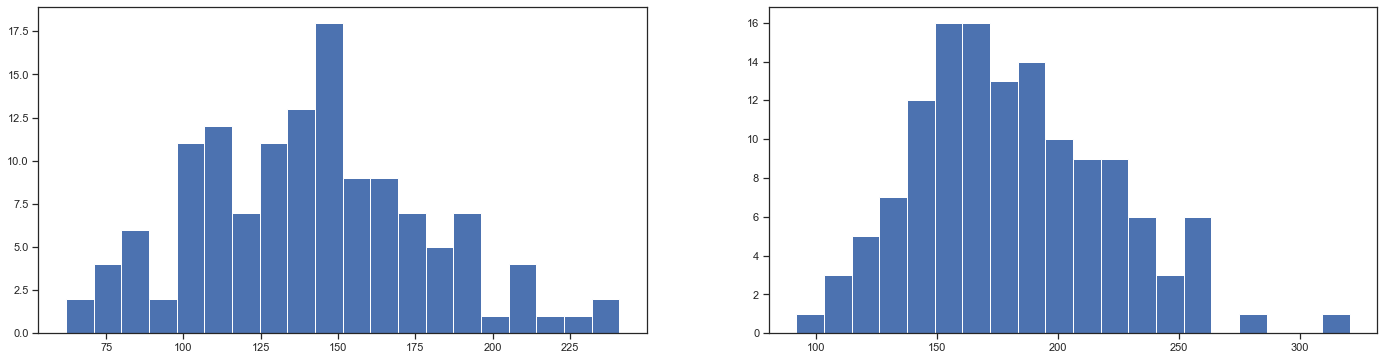

In [42]:
fig = plt.figure(figsize=(24, 6))

ax1 = plt.subplot(121)
plt.hist(acc_in_holidays, 20)

ax2 = plt.subplot(122)
plt.hist(acc_not_in_holidays, 20)

plt.show()

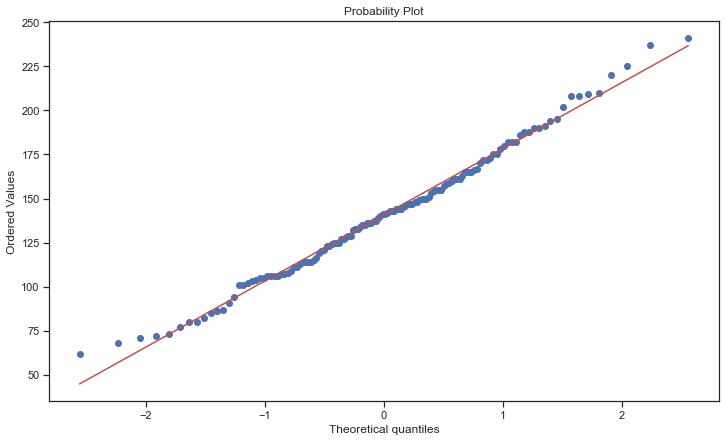

In [43]:
stats.probplot(acc_in_holidays, dist = "norm", plot = plt)
plt.show()

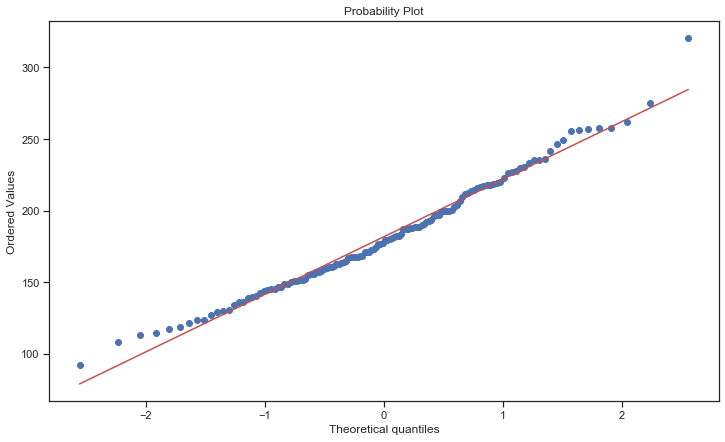

In [44]:
stats.probplot(acc_not_in_holidays, dist = "norm", plot = plt)
plt.show()

Есть подозрения на нормальность, **проверим гипотезу**:  
> H0 - число аварий распределено нормально

In [45]:
stats.shapiro(acc_in_holidays)

(0.9900091290473938, 0.462830513715744)

In [46]:
stats.shapiro(acc_not_in_holidays)

(0.9841341972351074, 0.12823869287967682)

### p>0.05!

Теперь можем вернуться к нашей гипотезе и применить к ней критерий Стьюдента для связанных выборок  
Его применимость возможна, так как:  
* Как мы уже показали величины имеют нормальное распределения
* Выборки рассматриваем как связанные, т.к. можно считать праздник экспериментом, который мы ставим над днём и известен результат до и после эксперимента

In [47]:
stats.ttest_rel(acc_in_holidays, acc_not_in_holidays)

Ttest_relResult(statistic=-13.495097269388841, pvalue=1.4799953192962625e-26)

Отвергаем гипотезу о не влиянии праздников!

### Проверим ещё одну гипотезу
> H0 - временной ряд стационарен

In [48]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, cutoff = 0.05):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    print(dfoutput)

In [49]:
test_stationarity(day_resample.Num_Acc)

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                   -4.847917
p-value                           0.000044
#Lags Used                       30.000000
Number of Observations Used    4352.000000
Critical Value (1%)              -3.431853
Critical Value (5%)              -2.862204
Critical Value (10%)             -2.567124
dtype: float64


Т.е ряд стационарен по критерию, но в нем есть тренд, видимо, критерий ошибается?

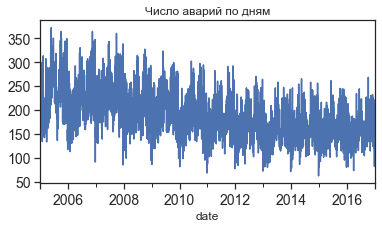

In [50]:
day_resample.Num_Acc.plot(figsize=(6,3),title= 'Число аварий по дням', fontsize=14)

# Построить предсказание временного ряда

Рассмотрим ряд из количества аварий по месяцам и применим к нему дифференцирования для стационарности

In [ ]:
new_series = pd.DataFrame()

In [52]:
df1.index = df1['date'] 
day_resample = df1.resample('M').count()

In [53]:
new_series['Num_Acc'] = day_resample.Num_Acc

Дифференцируем по очевидному сезонному лагу - годовому

In [54]:
new_series['Num_Acc_diff'] = new_series['Num_Acc'] - new_series['Num_Acc'].shift(12)

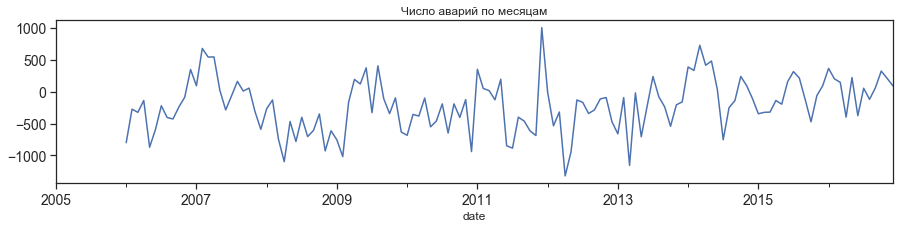

In [55]:
new_series.Num_Acc_diff.plot(figsize=(15,3),title= 'Число аварий по месяцам', fontsize=14)

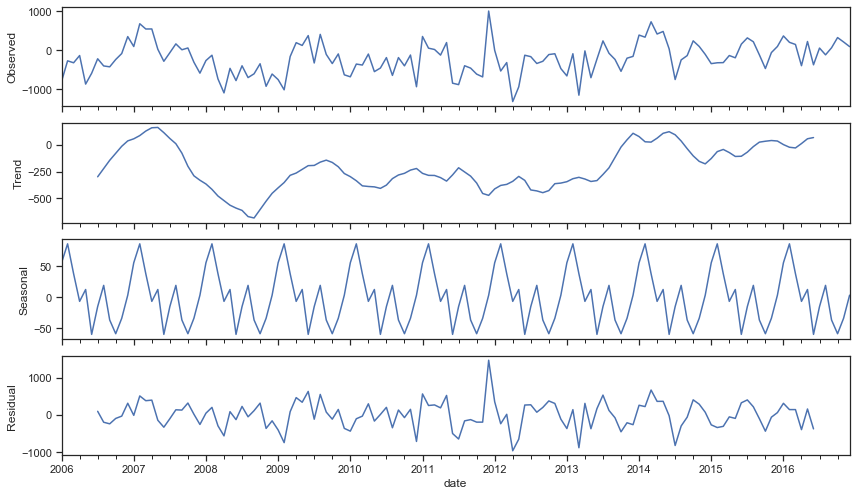

In [56]:
result = sm.tsa.seasonal_decompose(new_series.Num_Acc_diff[12:], model='additive')
result.plot()
plt.show()

Остался какой-то тренд, продифференцируем ещё раз

In [57]:
new_series['Num_Acc_diff_2'] = new_series['Num_Acc_diff'] - new_series['Num_Acc_diff'].shift(1)

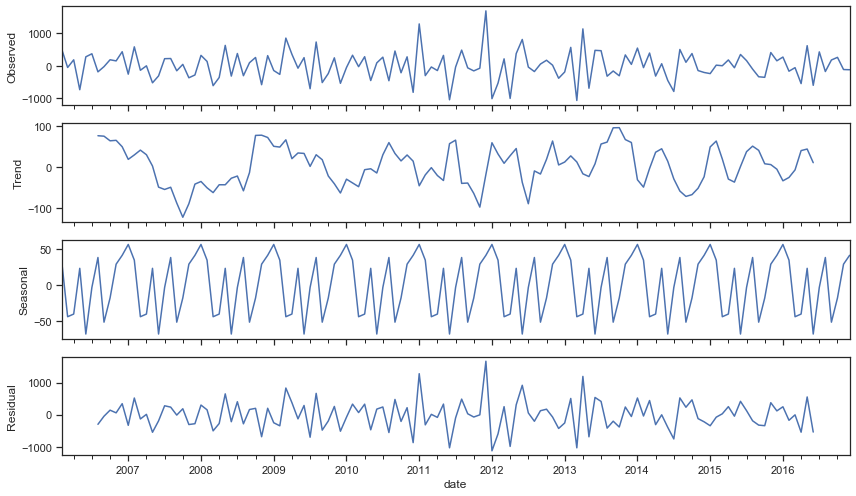

In [58]:
result = sm.tsa.seasonal_decompose(new_series.Num_Acc_diff_2[13:], model='additive')
result.plot()
plt.show()

Теперь ряд действительно стационарен и к нему применима модель **SARIMA**

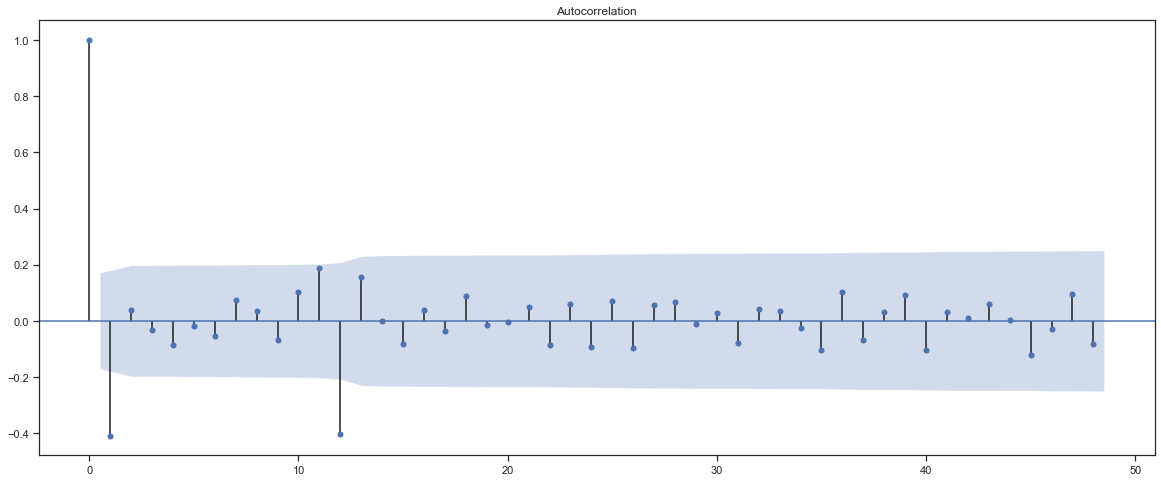

In [59]:
fig, ax = plt.subplots(figsize=(20,8))
sm.graphics.tsa.plot_acf(new_series.Num_Acc_diff_2[13:], lags=48, ax = ax)
plt.show()

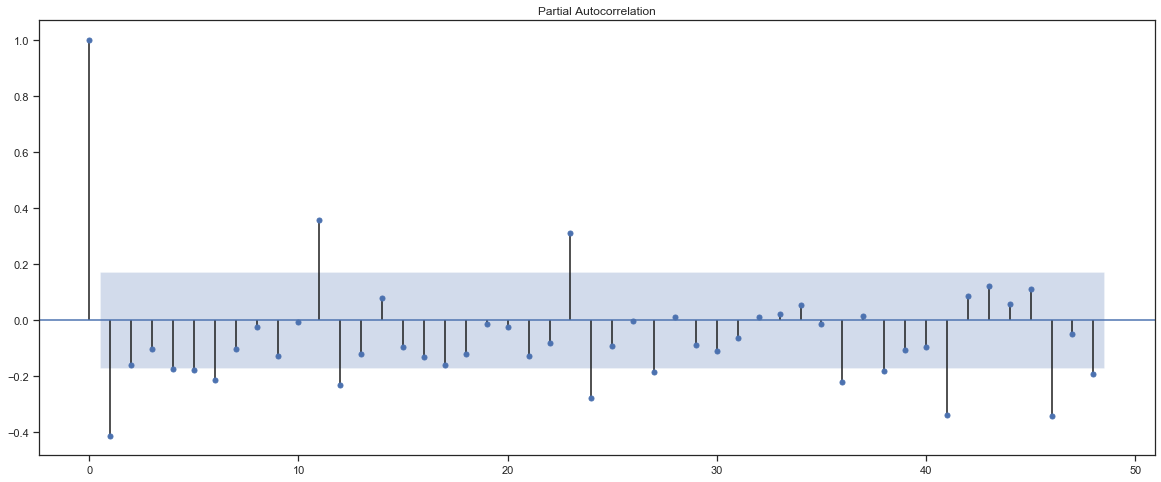

In [60]:
fig, ax = plt.subplots(figsize=(20,8))
sm.graphics.tsa.plot_pacf(new_series.Num_Acc_diff_2[13:], lags=48, ax = ax)
plt.show()

Подбираем начальные параметры:

In [61]:
Q=1
q=2
P=1
p=2

In [62]:
d = 1
D = 1
s = 24

ps = range(0, 3)
qs = range(0, 3)
Ps = range(0, 2)
Qs = range(0, 2)

In [63]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

Обучим модели и выберем лучшую

In [64]:
%%time
import warnings
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(new_series.Num_Acc, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 20.7 s, sys: 335 ms, total: 21.1 s
Wall time: 17.9 s


In [65]:
print(best_model.summary().tables[0])
print(best_model.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                            Num_Acc   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -940.887
Date:                            Wed, 04 Dec 2019   AIC                           1891.774
Time:                                    12:39:48   BIC                           1906.150
Sample:                                01-31-2005   HQIC                          1897.615
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3655      0.117      3.137      0.002       0.137       0.594
ma.L1         -0.8836      0.077   

### Изучим остатки

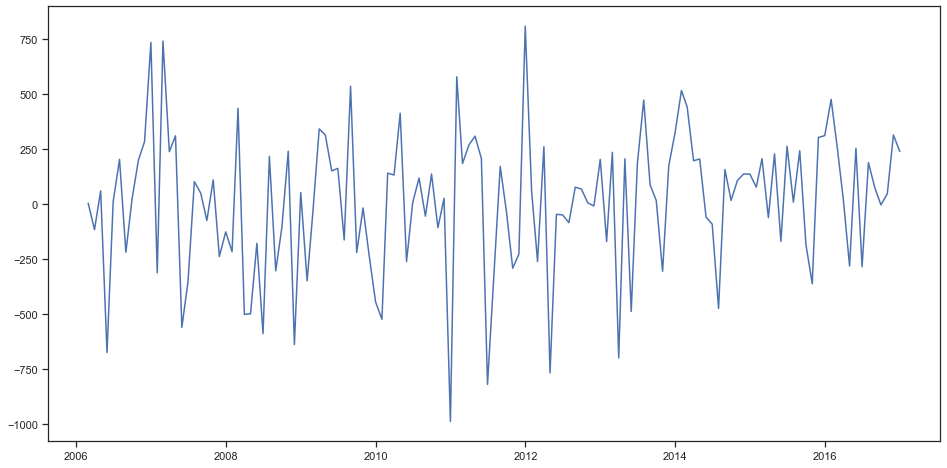

In [66]:
plt.figure(figsize=(16,8))
plt.plot(best_model.resid[13:])
plt.show()

In [67]:
print("Критерий Стьюдента несмещённости: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Критерий Стьюдента несмещённости: p=0.750036
Критерий Дики-Фуллера: p=0.000000


Остатки несмещенны и стационарны, т.е. похожи на шум

In [68]:
new_series['Model'] = best_model.fittedvalues

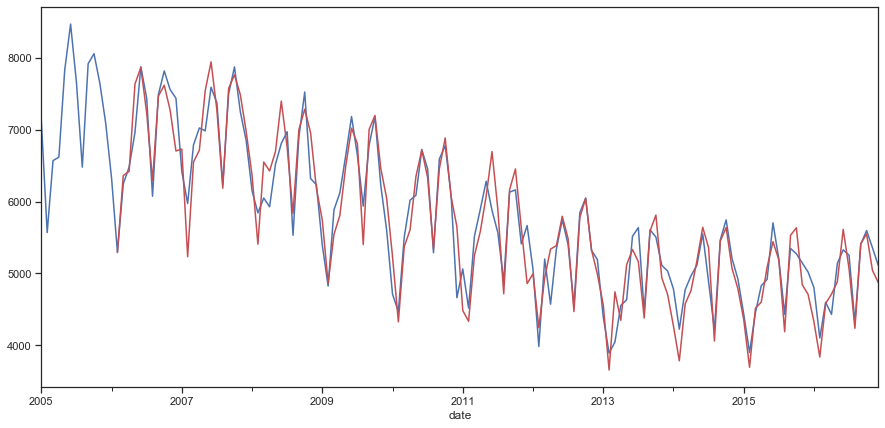

In [69]:
plt.figure(figsize=(15,7))
new_series.Num_Acc.plot()
new_series.Model[13:].plot(color='r')
plt.show()

In [70]:
forecast = best_model.predict(start = new_series['Num_Acc'].shape[0], end = new_series['Num_Acc'].shape[0]+12)

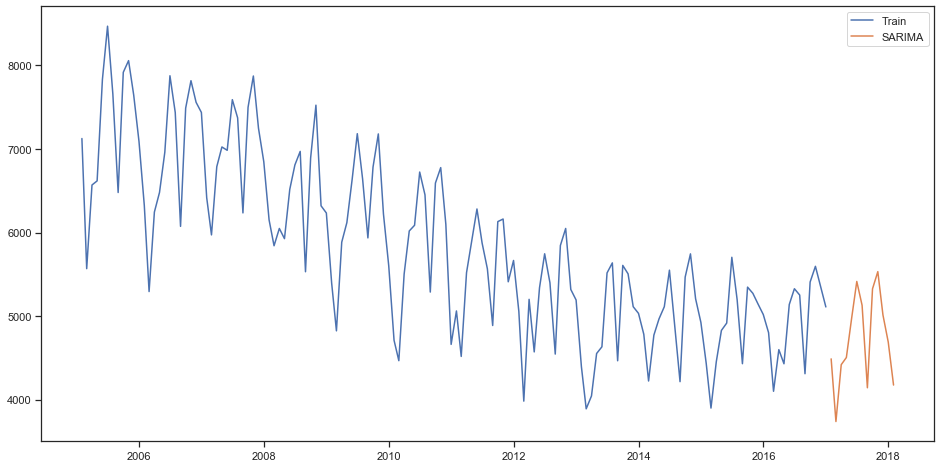

In [71]:
plt.figure(figsize=(16,8))
plt.plot(new_series['Num_Acc'], label='Train')
plt.plot(forecast, label='SARIMA')
plt.legend(loc='best')
plt.show()

**Получили прогноз на год вперёд!**

# Сделать выводы о проделанном исследовании

* Было проведенно исследование, визуализации и прогнозирование числа аварий на год вперёд.  
* Для себя я узнал много интересных фактов - о влиянии погоды, видимости, и других условий, дня недели на число проесшествий.  
* Лично для меня очень интересна была проверка гипотезы о влиянии праздников, в ходе которой было обнаружено, что число аварий имеет нормальное распределение!  
* Простые статистики (часы пик и самые опасные месяцы) так же несут массу информации, которую можно использовать, например, городским службам. Из сделанного прогноза можно заметить, что число аварий во Франции продолжит снижаться, что не может не радовать, как и гипотеза о том, что защитная экипировка действительно работает. 
* Итересно, что критерий Дики-Фуллера для исходного ряда с явно выраженным трендом утверждал стационарность, из-за чего не получалось построить адекватную модель SARIMA, но после дифференцирования результат заметно улучшился.